In [ ]:
# Load relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.stattools import adfuller

from google.colab import drive
drive.mount('/content/drive')

# data from https://www.kaggle.com/alaix14/bitcoin-tweets-20160101-to-20190329
DATA_DIR = '/content/drive/My Drive/MC/'

btcTwt = pd.read_csv(DATA_DIR + "bitcoin_sentiment_score.csv",error_bad_lines=False,lineterminator='\n')
btcPri = pd.read_csv(DATA_DIR + "BTC-USD.csv",error_bad_lines=False,lineterminator='\n')
print(btcTwt)
print(btcPri)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive
      Unnamed: 0        date  weight_avg
0              0  2013-07-04      -0.078
1              1  2013-07-05      -0.006
2              2  2013-07-06      -0.234
3              3  2013-07-07       0.334
4              4  2013-07-08      -0.182
...          ...         ...         ...
2228        2228  2019-08-14   27971.888
2229        2229  2019-08-15   24192.185
2230        2230  2019-08-16   17782.938
2231        2231  2019-08-17   12829.994
2232        2232  2019-08-18    2192.757

[2233 rows x 3 columns]
            Date          Open  ...     Adj Close       Volume
0     2014-09-17    465.864014  ...    457.334015     21056800
1     2014-09-18    456.859985  ...    424.440002     34483200
2     2014-09-19    424.102997  ...    394.795990     37919700
3     2014-09-20    394.673004  ...    408.903992     36863600
4     2014-09-21    408.084991  ...    398.821014     26580100
...          ...           ...  ...           ...          ...
1792  2019-08-14

      Unnamed: 0        date  weight_avg
0            437  2014-09-17       9.349
1            438  2014-09-18       4.129
2            439  2014-09-19       4.472
3            440  2014-09-20      13.101
4            441  2014-09-21       7.913
...          ...         ...         ...
1791        2228  2019-08-14   27971.888
1792        2229  2019-08-15   24192.185
1793        2230  2019-08-16   17782.938
1794        2231  2019-08-17   12829.994
1795        2232  2019-08-18    2192.757

[1796 rows x 3 columns]
            Date          Open  ...     Adj Close       Volume
0     2014-09-17    465.864014  ...    457.334015     21056800
1     2014-09-18    456.859985  ...    424.440002     34483200
2     2014-09-19    424.102997  ...    394.795990     37919700
3     2014-09-20    394.673004  ...    408.903992     36863600
4     2014-09-21    408.084991  ...    398.821014     26580100
...          ...           ...  ...           ...          ...
1792  2019-08-14  10889.487305  ...  10051

(-10000.0, 50000.0)

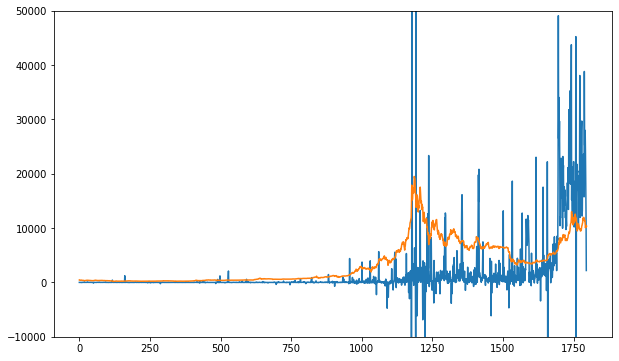

In [ ]:
newTwt = btcTwt[437:]
newTwt = newTwt.reset_index(drop=True)
print(newTwt)
print(btcPri)
fig = plt.figure(figsize=(10,6))
figure = plt.plot(newTwt['weight_avg'])
plt.plot(btcPri['Close'])
plt.ylim((-10000,50000))



In [ ]:
def run_strategy(data, lookback, width):
   df = data.copy()
   df['weight_avg'] = df["weight_avg"]
   df['BTC Adj Close'] = df['Close'] - df['Close'].rolling(lookback).mean()
   df['ratio'] = df['BTC Adj Close'] / df['weight_avg']
   
   df['rolling_spread'] = df['ratio'].rolling(lookback).mean() #lookback-day SMA of spread
   df['rolling_spread_std'] = df['ratio'].rolling(lookback).std() #lookback-day rolling STD of spread
   df['upper_band'] = df['rolling_spread'] + (width * df['rolling_spread_std']) #upper = SMA + width * STD
   df['lower_band'] = df['rolling_spread'] - (width * df['rolling_spread_std']) #lower = SMA - width * STD

   df['Position BTC'] = np.nan
   for date in df.index:
      if df.loc[date, 'ratio'] > df.loc[date, 'upper_band']: 
         df.loc[date, 'Position BTC'] = -1
      elif df.loc[date, 'ratio'] < df.loc[date, 'lower_band']:
         df.loc[date, 'Position BTC'] = 1
      else:
         df.loc[date, 'Position BTC'] = 0
  
   df['P&L'] = df['Position BTC'] * df['Close'].diff().shift(-1)

   return df

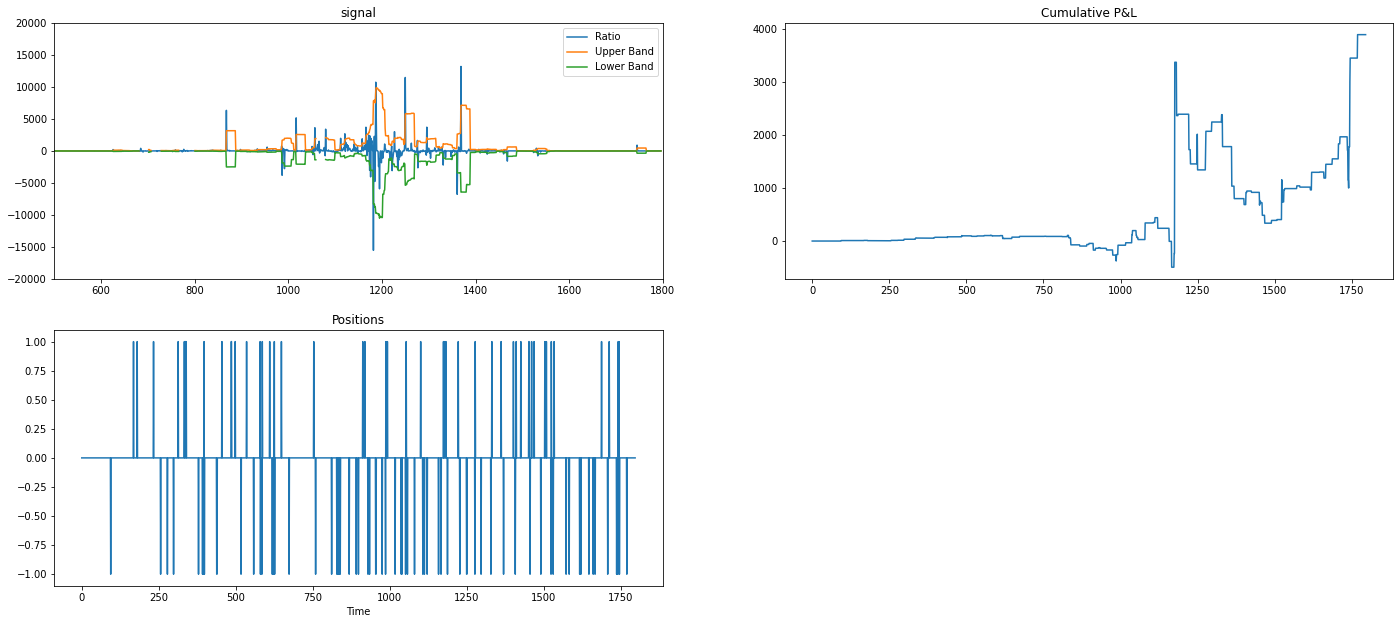

In [ ]:
btcPri["weight_avg"] = btcTwt['weight_avg']
standard_BB_train_df = run_strategy(btcPri, 20, 2) #20-day and 2 STD are the standard BB parameters used

#plot intermediate and final results of using these parameters on training data
fig = plt.figure(figsize=(24,16)) #overall plot size
ax3 = fig.add_subplot(321)
ax4 = fig.add_subplot(322)
ax5 = fig.add_subplot(323)

#ax2.plot(standard_BB_train_df['spread'])
#ax2.set_title("Spread")

ax3.plot(standard_BB_train_df['ratio'], label = 'Ratio')
ax3.plot(standard_BB_train_df['upper_band'], label = 'Upper Band')
ax3.plot(standard_BB_train_df['lower_band'], label = 'Lower Band')
ax3.set_xlim([500,1800])
ax3.set_ylim([-20000,20000])
ax3.set_title("signal")
ax3.legend(loc="upper right")

ax4.plot(standard_BB_train_df['P&L'].cumsum()) #note: we use cumsum here to see *cumulative* profit
ax4.set_title("Cumulative P&L")

ax5.plot(standard_BB_train_df['Position BTC'], label = "BTC")
# ax5.plot(standard_BB_train_df['Position GDXJ'], label = "GDXJ")
ax5.set_title("Positions")

plt.xlabel("Time")
plt.show()

In [ ]:
def get_sharpe(r, rfr=0.02):
  if r.std():
    return (r.mean()-rfr) / r.std() * np.sqrt(252)
  return 0

print('Sharpe ratio:', get_sharpe(standard_BB_train_df['P&L']))

Sharpe ratio: 0.3117525080570577


In [ ]:
trainTwt = btcTwt[0:1500]
trainPri = btcPri[0:1500]
trainPri["weight_avg"] = trainTwt['weight_avg']

testTwt = btcTwt[1500:]
testPri = btcPri[1500:]
testPri["weight_avg"] = testTwt['weight_avg']

maxSharpe = 0
bestLookback = 0
bestWidth = 0

train_sharpes = []

lookbacks = []
for lookback in np.linspace(start=2, stop=8, num=8) * 10:
  lookback = int(lookback)
  print("A")
  widths = []
  for width in np.linspace(start=1, stop=3, num=10):
      df = run_strategy(trainPri, lookback, width)
      sharpe = get_sharpe(df['P&L'])

      if sharpe > maxSharpe:
        maxSharpe = sharpe
        bestLookback = lookback
        bestWidth = width

      train_sharpes.append({'window': lookback, 'width': width, 'sharpe': sharpe})
        
      widths.append(sharpe)

  lookbacks.append(widths)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


A
A
A
A
A
A
A
A


In [ ]:
print(maxSharpe)
print(bestLookback)
print(bestWidth)

0.36011844642200463
62
2.333333333333333


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


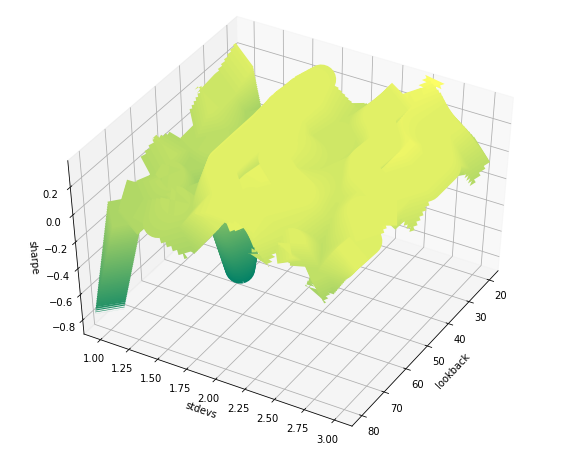

In [ ]:
fig = plt.figure(figsize=(10,8))
X = np.linspace(start=2, stop=8, num=8)
Y = np.linspace(start=1, stop=3, num=10)

X,Y = np.meshgrid(np.linspace(start=2, stop=8, num=8) * 10, np.linspace(start=1, stop=3, num=10))

ax = fig.add_subplot(111, projection="3d")
Z = []
for j in range(len(np.linspace(start=1, stop=3, num=10))):
  row = []
  for k in range(len(np.linspace(start=2, stop=8, num=8))):
    row.append(train_sharpes[j*len(np.linspace(start=2, stop=8, num=8))+k]['sharpe'])
  Z.append(row)
Z = np.array(Z)
ax.contour3D(X, Y, Z, 100, cmap='summer', linewidths=30)
ax.set_xlabel('lookback')
ax.set_ylabel('stdevs')
ax.set_zlabel('sharpe')
ax.view_init(45, 30)

plt.show()


0     0.222199
1     0.125424
2     0.137071
3    -0.011305
4     0.063834
        ...   
75    0.177825
76    0.076680
77    0.340921
78    0.213920
79    0.239021
Name: sharpe, Length: 80, dtype: float64
0.08005808268629552
Mean: 0.08, STD: 0.24


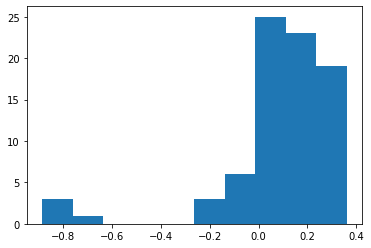

In [ ]:
sharpes = []
for i in range(len(train_sharpes)):
  sharpes.append(train_sharpes[i]['sharpe'])

sharpes = pd.DataFrame(sharpes)
sharpes['sharpe'] = sharpes


print(sharpes['sharpe'])
print(sharpes['sharpe'].mean())


train_sharpes_SRs_only = np.array([d['sharpe'] for d in train_sharpes])
print('Mean: %.2f, STD: %.2f' % (train_sharpes_SRs_only.mean(), train_sharpes_SRs_only.std()))

plt.hist(train_sharpes_SRs_only)
plt.show()

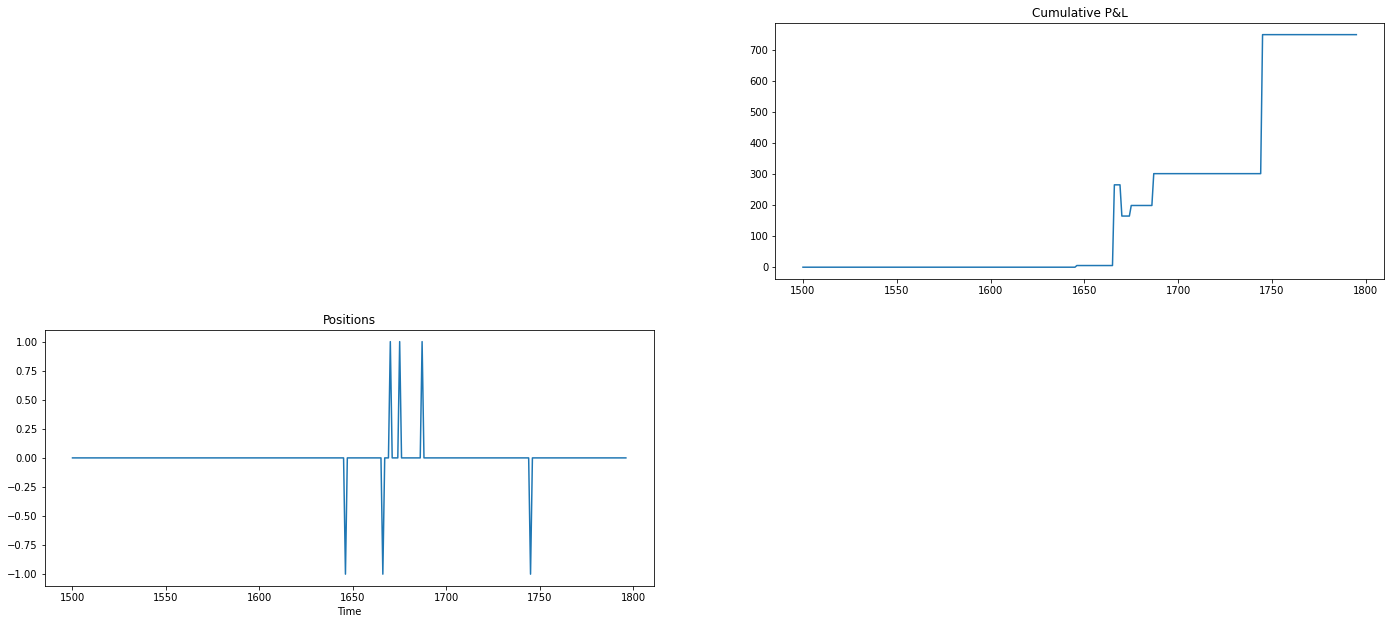

In [ ]:
standard_BB_train_df = run_strategy(testPri, bestLookback, bestWidth) #20-day and 2 STD are the standard BB parameters used

#plot intermediate and final results of using these parameters on training data
fig = plt.figure(figsize=(24,16)) #overall plot size
ax4 = fig.add_subplot(322)
ax5 = fig.add_subplot(323)

#ax1.plot(standard_BB_train_df['hedge_ratio'])
#ax1.set_title("Hedge Ratio")

#ax2.plot(standard_BB_train_df['spread'])
#ax2.set_title("Spread")

# ax3.plot(standard_BB_train_df['spread'], label = 'Spread')
# ax3.plot(standard_BB_train_df['rolling_spread'], label = 'Spread 20-Day SMA')
# ax3.plot(standard_BB_train_df['upper_band'], label = 'Upper BB')
# ax3.plot(standard_BB_train_df['lower_band'], label = 'Lower BB')
# ax3.set_title("Bollinger Bands")
# ax3.legend(loc="upper right")

ax4.plot(standard_BB_train_df['P&L'].cumsum()) #note: we use cumsum here to see *cumulative* profit
ax4.set_title("Cumulative P&L")

ax5.plot(standard_BB_train_df['Position BTC'], label = "BTC")
# ax5.plot(standard_BB_train_df['Position GDXJ'], label = "GDXJ")
ax5.set_title("Positions")

plt.xlabel("Time")
plt.show()

In [ ]:
print(get_sharpe(standard_BB_train_df['P&L']))
print(2*sharpes['sharpe'].std())
print("range: ",get_sharpe(standard_BB_train_df['P&L'])-2*sharpes['sharpe'].std(),", ",get_sharpe(standard_BB_train_df['P&L'])+2*sharpes['sharpe'].std())

1.2756395260650568
0.4872022258692228
range:  0.788437300195834 ,  1.7628417519342796
